# Customer Churn Prediction Analysis (Fixed Version)

This notebook provides an interactive analysis of customer churn prediction using AWS SageMaker and local ML models.

## Project Overview
- **Objective**: Predict which subscription customers are likely to churn
- **AWS Services**: S3, SageMaker, (optional) Lambda
- **ML Algorithm**: XGBoost for binary classification
- **Key Metrics**: AUC Score, Precision, Recall, Feature Importance

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
import os

# Smart path handling - works from both project root and notebooks directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Add both possible paths for imports
paths_to_add = ['src', '../src', './src']
for path in paths_to_add:
    if path not in sys.path:
        sys.path.append(path)

try:
    from utils import generate_churn_data, calculate_model_metrics
    from visualize import create_eda_visualizations, create_model_performance_charts
    print("✅ All imports successful!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure you're running from the project root or notebooks directory")

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Setup complete!")

Current directory: /Users/kuldeepghate/Documents/Projects/Churn-Prediction-For-Subscription-Customers/churn-prediction/notebooks
✅ All imports successful!
✅ Setup complete!


## 1. Data Loading and Exploration

In [6]:
# Smart data loading - try multiple paths
def load_data_smart(filename):
    """Load data from multiple possible locations"""
    possible_paths = [
        f'data/{filename}',      # From project root
        f'../data/{filename}',   # From notebooks directory
        f'./{filename}',         # Current directory
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ Loading data from: {path}")
            return pd.read_csv(path)
    
    raise FileNotFoundError(f"Could not find {filename} in any of these locations: {possible_paths}")

# Load the datasets
try:
    train_data = load_data_smart('train_data.csv')
    test_data = load_data_smart('test_data.csv')
    customers_to_predict = load_data_smart('customers_to_predict.csv')
    
    print(f"\n📊 Dataset Summary:")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Customers to predict: {customers_to_predict.shape}")
    print(f"Churn rate in training data: {train_data['churned'].mean():.2%}")
    
except FileNotFoundError as e:
    print(f"❌ {e}")
    print("\n🔧 Generating sample data...")
    train_data, test_data, customers_to_predict = generate_churn_data(n_samples=1000, test_split=0.2)
    print("✅ Sample data generated successfully!")

✅ Loading data from: ../data/train_data.csv
✅ Loading data from: ../data/test_data.csv
✅ Loading data from: ../data/customers_to_predict.csv

📊 Dataset Summary:
Training data shape: (4000, 13)
Test data shape: (1000, 13)
Customers to predict: (1000, 12)
Churn rate in training data: 34.45%


In [7]:
# Display basic information about the dataset
print("📋 Dataset Info:")
print(train_data.info())
print("\n📊 First 5 rows:")
train_data.head()

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        4000 non-null   object 
 1   age                4000 non-null   int64  
 2   tenure_months      4000 non-null   int64  
 3   monthly_charges    4000 non-null   float64
 4   total_charges      4000 non-null   float64
 5   contract_type      4000 non-null   object 
 6   payment_method     4000 non-null   object 
 7   internet_service   4000 non-null   object 
 8   support_calls      4000 non-null   int64  
 9   avg_call_duration  4000 non-null   float64
 10  data_usage_gb      4000 non-null   float64
 11  login_frequency    4000 non-null   int64  
 12  churned            4000 non-null   int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 406.4+ KB
None

📊 First 5 rows:


,customer_id,age,tenure_months,monthly_charges,total_charges,contract_type,payment_method,internet_service,support_calls,avg_call_duration,data_usage_gb,login_frequency,churned
0,CUST_000001,40,4,41.54,255.19,One year,Bank transfer,Fiber optic,2,11.4,11.13,15,0
1,CUST_000002,33,5,51.34,348.18,Month-to-month,Credit card,Fiber optic,1,8.8,53.00,14,0
2,CUST_000003,42,14,57.94,782.45,Two year,Mailed check,No,0,1.7,62.60,17,0
3,CUST_000004,53,8,91.27,742.81,Month-to-month,Bank transfer,Fiber optic,3,32.5,5.37,9,1
4,CUST_000005,32,6,35.93,144.10,Month-to-month,Credit card,Fiber optic,3,1.6,24.37,18,0


In [8]:
# Statistical summary
print("📈 Statistical Summary:")
train_data.describe()

📈 Statistical Summary:


,age,tenure_months,monthly_charges,total_charges,support_calls,avg_call_duration,data_usage_gb,login_frequency,churned
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,35.162000,21.645000,64.954847,1404.244288,1.974750,8.077800,32.422135,14.931250,0.344500
std,11.153894,19.685791,23.932987,1454.598325,1.418667,7.940071,40.768380,3.804358,0.475264
min,18.000000,1.000000,15.000000,15.000000,0.000000,0.000000,0.680000,3.000000,0.000000
25%,27.000000,6.000000,48.507500,358.192500,1.000000,2.400000,10.030000,12.000000,0.000000
50%,35.000000,15.000000,64.735000,896.245000,2.000000,5.650000,19.395000,15.000000,0.000000
75%,43.000000,31.000000,81.117500,1959.517500,3.000000,11.400000,38.817500,17.000000,1.000000
max,75.000000,72.000000,149.440000,8323.340000,10.000000,65.400000,491.370000,30.000000,1.000000


## 2. Exploratory Data Analysis

In [9]:
# Create comprehensive EDA visualizations
print("📊 Creating exploratory data analysis...")

# Determine save path
viz_paths = ['visualizations/charts', '../visualizations/charts']
save_path = None
for path in viz_paths:
    if os.path.exists(os.path.dirname(path)) or os.path.exists(path):
        save_path = path
        break

if save_path is None:
    save_path = 'charts'  # Create in current directory
    os.makedirs(save_path, exist_ok=True)

create_eda_visualizations(train_data, save_path=save_path)
print(f"✅ EDA visualizations saved to {save_path}/")

📊 Creating exploratory data analysis...
EDA visualizations saved to ../visualizations/charts/
✅ EDA visualizations saved to ../visualizations/charts/


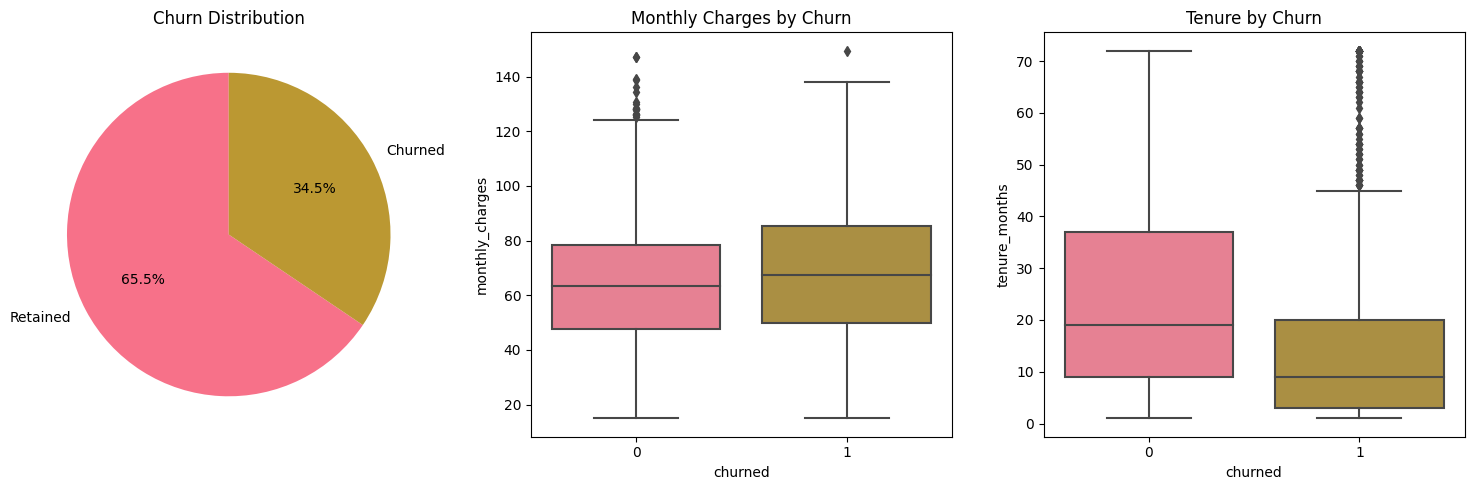

In [10]:
# Display churn distribution inline
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
churn_counts = train_data['churned'].value_counts()
plt.pie(churn_counts.values, labels=['Retained', 'Churned'], autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(data=train_data, x='churned', y='monthly_charges')
plt.title('Monthly Charges by Churn')

plt.subplot(1, 3, 3)
sns.boxplot(data=train_data, x='churned', y='tenure_months')
plt.title('Tenure by Churn')

plt.tight_layout()
plt.show()

## 3. Quick Model Training

In [11]:
# Quick local model training
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

print("🔧 Training quick XGBoost model...")

# Preprocess data
data = train_data.copy()

# Encode categorical variables
label_encoders = {}
categorical_cols = ['contract_type', 'payment_method', 'internet_service']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Feature engineering
data['charges_per_month_tenure'] = data['monthly_charges'] / (data['tenure_months'] + 1)
data['total_charges_per_tenure'] = data['total_charges'] / (data['tenure_months'] + 1)
data['avg_monthly_usage'] = data['data_usage_gb'] / (data['tenure_months'] + 1)
data['support_calls_per_month'] = data['support_calls'] / (data['tenure_months'] + 1)

# Prepare features and target
X = data.drop(['churned', 'customer_id'], axis=1)
y = data['churned']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

🔧 Training quick XGBoost model...
Training set: (3200, 15)
Validation set: (800, 15)


In [12]:
# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

# Fit model
model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          early_stopping_rounds=10, 
          verbose=False)

print("✅ Model training completed!")

✅ Model training completed!


/Users/kuldeepghate/Documents/Projects/Churn-Prediction-For-Subscription-Customers/churn-prediction/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [13]:
# Make predictions and evaluate
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

# Calculate metrics
metrics = calculate_model_metrics(y_val, y_pred, y_prob)

print("🎯 Model Performance:")
print(f"AUC Score: {metrics['auc_score']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Retained', 'Churned']))

🎯 Model Performance:
AUC Score: 0.8059
Accuracy: 0.7512
Precision: 0.6842
Recall: 0.5181
F1 Score: 0.5897

📊 Classification Report:
              precision    recall  f1-score   support

    Retained       0.77      0.87      0.82       524
     Churned       0.68      0.52      0.59       276

    accuracy                           0.75       800
   macro avg       0.73      0.70      0.71       800
weighted avg       0.74      0.75      0.74       800



🔍 Top 10 Most Important Features:
                     feature  importance
4              contract_type    0.298702
1              tenure_months    0.142589
11  charges_per_month_tenure    0.074830
7              support_calls    0.061923
5             payment_method    0.052712
14   support_calls_per_month    0.047845
2            monthly_charges    0.044371
3              total_charges    0.038898
6           internet_service    0.037345
12  total_charges_per_tenure    0.037175


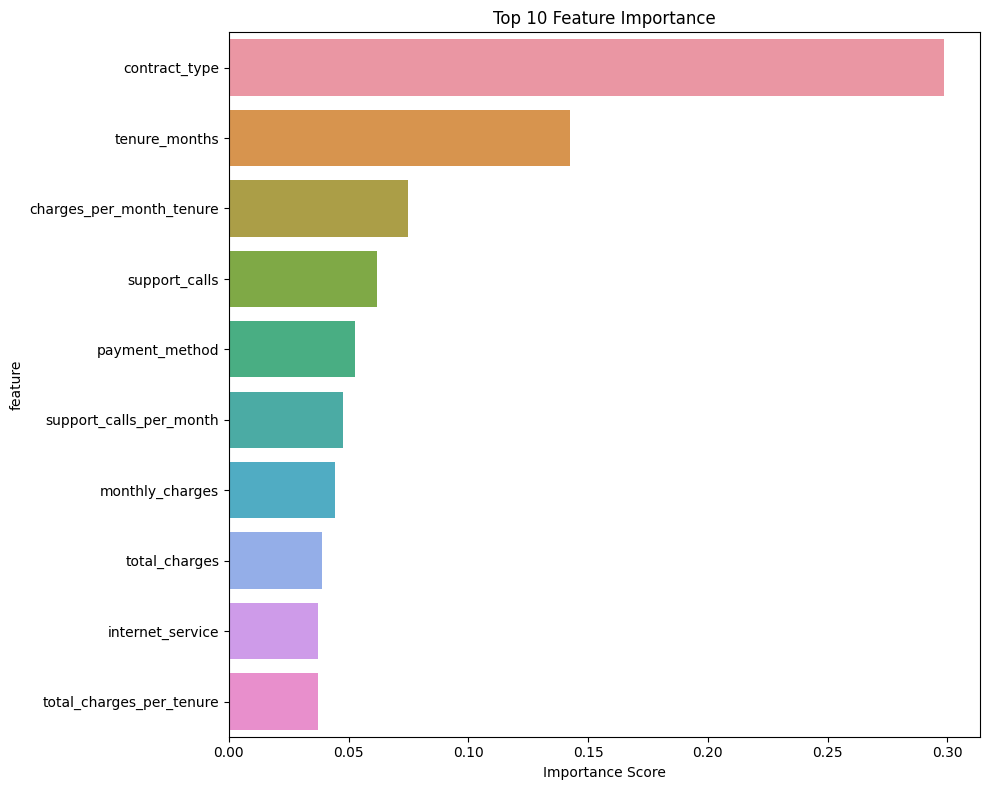

In [14]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## 4. Business Insights

In [15]:
# Generate business insights
print("💼 BUSINESS INSIGHTS")
print("=" * 50)

# Contract type analysis
contract_churn = train_data.groupby('contract_type')['churned'].agg(['count', 'sum', 'mean'])
contract_churn['churn_rate'] = contract_churn['mean']

print("\n📋 Churn Rate by Contract Type:")
for contract, row in contract_churn.iterrows():
    print(f"  • {contract}: {row['churn_rate']:.1%} ({row['sum']}/{row['count']} customers)")

# Payment method analysis
payment_churn = train_data.groupby('payment_method')['churned'].mean().sort_values(ascending=False)
print("\n💳 Churn Rate by Payment Method:")
for method, rate in payment_churn.items():
    print(f"  • {method}: {rate:.1%}")

# Support calls analysis
high_support = train_data[train_data['support_calls'] >= 3]
print(f"\n📞 Customers with 3+ support calls: {len(high_support)} ({len(high_support)/len(train_data):.1%})")
print(f"   Churn rate: {high_support['churned'].mean():.1%}")

# Tenure analysis
new_customers = train_data[train_data['tenure_months'] <= 6]
print(f"\n🆕 New customers (≤6 months): {len(new_customers)} ({len(new_customers)/len(train_data):.1%})")
print(f"   Churn rate: {new_customers['churned'].mean():.1%}")

print("\n💡 KEY RECOMMENDATIONS:")
print("1. 🎁 Target month-to-month customers with contract upgrade incentives")
print("2. 💳 Encourage electronic check users to switch payment methods")
print("3. 📞 Proactive outreach for customers with multiple support calls")
print("4. 🆕 Enhanced onboarding program for new customers")
print("5. 📊 Regular monitoring of high-risk customer segments")

💼 BUSINESS INSIGHTS

📋 Churn Rate by Contract Type:
  • Month-to-month: 48.9% (978.0/2000.0 customers)
  • One year: 24.9% (309.0/1239.0 customers)
  • Two year: 12.0% (91.0/761.0 customers)

💳 Churn Rate by Payment Method:
  • Electronic check: 43.4%
  • Bank transfer: 31.2%
  • Mailed check: 30.0%
  • Credit card: 27.7%

📞 Customers with 3+ support calls: 1228 (30.7%)
   Churn rate: 40.0%

🆕 New customers (≤6 months): 1033 (25.8%)
   Churn rate: 57.6%

💡 KEY RECOMMENDATIONS:
1. 🎁 Target month-to-month customers with contract upgrade incentives
2. 💳 Encourage electronic check users to switch payment methods
3. 📞 Proactive outreach for customers with multiple support calls
4. 🆕 Enhanced onboarding program for new customers
5. 📊 Regular monitoring of high-risk customer segments


## 5. Next Steps

This notebook demonstrates the core churn prediction analysis. For production deployment:

1. **AWS SageMaker Training**: Use `python src/train.py` for cloud-based training
2. **Model Deployment**: Deploy to SageMaker endpoint for real-time predictions
3. **Batch Predictions**: Use `python src/predict.py` for bulk customer scoring
4. **Monitoring**: Set up model performance tracking and retraining pipelines
5. **Integration**: Connect predictions to CRM and marketing automation systems

**Project Status**: ✅ Analysis Complete | 🚀 Ready for Production Deployment